# Data loading

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
from dateutil.parser import parse
import cpi

## Load CMU Movie Summary Corpus dataset

In [11]:
#Load characters metadata
names = ['Wikipedia movie ID','Freebase movie ID','Movie release date','Character name','Actor date of birth','Actor gender','Actor height (in meters)','Actor ethnicity (Freebase ID)','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
characters = pd.read_csv("./data/MovieSummaries/character.metadata.tsv", sep='\t', header=None, names=names).drop(columns = ["Movie release date"])

# store the release date as datetime objects
characters["Actor date of birth"] = characters["Actor date of birth"].apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT)

# Convert data types to integers for specific columns
columns = ["Actor age at movie release"]
for column in columns:
  characters[column] = characters[column].astype("Int64")

characters.head()

,Wikipedia movie ID,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [12]:
#Load characters metadata
names = ['Wikipedia movie ID','Freebase movie ID','Movie release date','Character name','Actor date of birth','Actor gender','Actor height (in meters)','Actor ethnicity (Freebase ID)','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
characters = pd.read_csv("./data/MovieSummaries/character.metadata.tsv", sep='\t', header=None, names=names).drop(columns = ["Movie release date"])

# store the release date as datetime objects
characters["Actor date of birth"] = characters["Actor date of birth"].apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT)

# Convert data types to integers for specific columns
columns = ["Actor age at movie release"]
for column in columns:
  characters[column] = characters[column].astype("Int64")

characters.head()

,Wikipedia movie ID,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
#Load movies metadata
names = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
movies = pd.read_csv("./data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, names=names)

# correct manualy the mistake in the date 1010-12-02 to 2010-12-02 on index 62836
movies.loc[62836, "Movie release date"] = "2010-12-02"

# store the release date as datetime objects
movies["Movie release date"] = movies["Movie release date"].apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT)

# populate a column with only the year in numerical format
movies["Movie release year"] = movies["Movie release date"].dt.year

# Convert data types to integers for specific columns
columns = ["Movie release year","Movie release year"]
for column in columns:
  movies[column] = movies[column].astype("Int64")

movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988-11-17,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987-11-17,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983-11-17,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


### Adjust Box office revenues

First, let's plot the box office revenues of the movie over the years to have an overview of the data distribution.

<Axes: xlabel='Movie release year', ylabel='Movie box office revenue'>

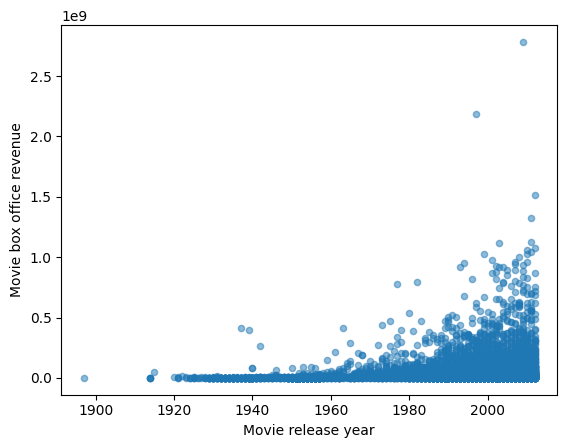

In [14]:
movies.plot(x="Movie release year", y="Movie box office revenue", kind="scatter", alpha=0.5)

From the plot, we can see that the movie revenues over the years follow an exponential distribution. This is due to the compounding effect of monetary inflation year over year. We can take account of this and adjust the revenues in usd using inflation data given by the US Consumer price index (CPI)

<Axes: xlabel='Movie release year', ylabel='Inflation-adjusted box office revenue'>

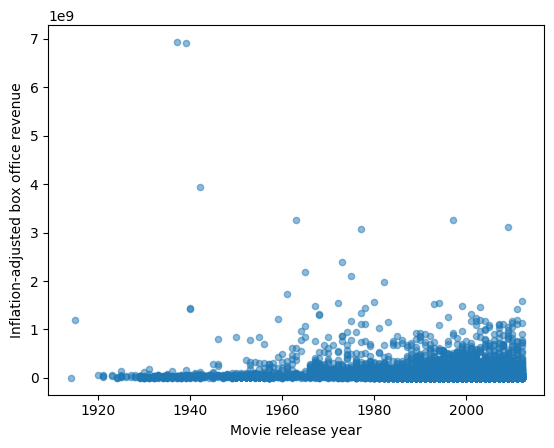

In [15]:
# Take the latest available year of the dataset as reference
max_year = movies["Movie release year"].max()

# Update CPI data
cpi.update()

# Adjust dollars revenues for inflation
movies["Inflation-adjusted box office revenue"] = movies.dropna().apply(lambda row: cpi.inflate(row["Movie box office revenue"], row["Movie release year"], to=max_year),axis=1)
# Plot the Inflation-adjusted revenues
movies.plot(x="Movie release year", y="Inflation-adjusted box office revenue", kind="scatter", alpha=0.5)

Although other effects can affect the revenue distribution over the years, the resulting plot shows a more uniform trend than the previous one

## Load IMDb ratings dataset

In [16]:
# Load the titles dataset
titles = pd.read_csv("./data/IMDb/titles.tsv", sep='\t', usecols=[0,2])
display(titles.head())

# Load the details of each title (movies)
titles_details = pd.read_csv("./data/IMDb/titles_details.tsv", sep='\t', usecols=[0,5])
display(titles_details.head())

# Load the ratings dataset
ratings = pd.read_csv("./data/IMDb/ratings.tsv", sep='\t')
ratings = ratings.rename(columns={'averageRating': 'Average rating', 'numVotes': 'Number of votes'})

# Convert data types to integers for specific columns
columns = ["Number of votes"]
for column in columns:
  ratings[column] = ratings[column].astype("Int64")

display(ratings.head())

,titleId,title
0,tt0000001,Карменсіта
1,tt0000001,Carmencita
2,tt0000001,Carmencita - spanyol tánc
3,tt0000001,Καρμενσίτα
4,tt0000001,Карменсита


,tconst,startYear
0,tt0000001,1894
1,tt0000002,1892
2,tt0000003,1892
3,tt0000004,1892
4,tt0000005,1893


,tconst,Average rating,Number of votes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


## Merge the datasets

Resulting usable dataframes are:

- movies: includes each movie with the ratings but without the details of the characters

- characters_movies: includes each character with its corresponding movie and ratings

In [17]:
# Merge the different IMDb datasets together, then delete no longer relevant dataframes to free the RAM
titles = pd.merge(titles, titles_details, left_on="titleId", right_on="tconst")
del titles_details
ratings = pd.merge(ratings, titles, on="tconst")
del titles
# convert the years to integers using datetime
ratings["startYear"] = ratings["startYear"].astype(str).replace(r'\N', np.nan).apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT).dt.year.astype('Int64')
ratings.head()

,tconst,Average rating,Number of votes,titleId,title,startYear
0,tt0000001,5.7,2006,tt0000001,Карменсіта,1894
1,tt0000001,5.7,2006,tt0000001,Carmencita,1894
2,tt0000001,5.7,2006,tt0000001,Carmencita - spanyol tánc,1894
3,tt0000001,5.7,2006,tt0000001,Καρμενσίτα,1894
4,tt0000001,5.7,2006,tt0000001,Карменсита,1894


In [18]:
# Merge the movies dataset (CMU) with the ratins dataset (IMDb), remove duplicates and delete no longer relevant dataframe to free the RAM
movies = pd.merge(movies, ratings, left_on=["Movie name","Movie release year"], right_on=["title","startYear"], how="left").drop_duplicates().drop(columns=["tconst","titleId","title","startYear"]).drop_duplicates(['Freebase movie ID'])
del ratings

# Clean languages, countries and genres columns by removing unnecessary ID's
columns = ["Movie languages","Movie countries","Movie genres"]
for column in columns:
  movies[column] = movies[column].apply(lambda string: list(json.loads(string).values()))

movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Inflation-adjusted box office revenue,Average rating,Number of votes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
11,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,NaN,NaN,<NA>
12,28463795,/m/0crgdbh,Brun bitter,1988-11-17,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaN,5.6,40
14,9363483,/m/0285_cd,White Of The Eye,1987-11-17,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaN,NaN,<NA>
15,261236,/m/01mrr1,A Woman in Flames,1983-11-17,NaN,106.0,[German Language],[Germany],[Drama],1983,NaN,5.9,623


In [19]:
# Final merge between the characters and movies dataset
characters_movies = characters.merge(movies, on=["Freebase movie ID","Wikipedia movie ID"])

# Clean the dataset by removing the Freebase ID's in the database (might be useful to keep the ID's in the future though)
characters_movies = characters_movies.drop(columns=["Wikipedia movie ID","Freebase movie ID","Freebase character ID","Freebase actor ID","Freebase character/actor map ID"])

characters_movies.head()

,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Inflation-adjusted box office revenue,Average rating,Number of votes
0,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
1,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
2,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
3,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
4,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912


## Data cleaning and verification

In [20]:
# Check that every element in each column of the dataframes have the same type
display(movies.dtypes)
display(characters_movies.dtypes)

Wikipedia movie ID                                int64
Freebase movie ID                                object
Movie name                                       object
Movie release date                       datetime64[ns]
Movie box office revenue                        float64
Movie runtime                                   float64
Movie languages                                  object
Movie countries                                  object
Movie genres                                     object
Movie release year                                Int64
Inflation-adjusted box office revenue           float64
Average rating                                  float64
Number of votes                                   Int64
dtype: object

Character name                                   object
Actor date of birth                              object
Actor gender                                     object
Actor height (in meters)                        float64
Actor ethnicity (Freebase ID)                    object
Actor name                                       object
Actor age at movie release                        Int64
Movie name                                       object
Movie release date                       datetime64[ns]
Movie box office revenue                        float64
Movie runtime                                   float64
Movie languages                                  object
Movie countries                                  object
Movie genres                                     object
Movie release year                                Int64
Inflation-adjusted box office revenue           float64
Average rating                                  float64
Number of votes                                 

## Store the generated dataframes in binary format

In [21]:
movies.to_pickle("./data/movies_df_pickle")
characters_movies.to_pickle("./data/characters_movies_df_pickle")

# Temporal analysis of box office

Reload the dataset:

In [68]:
movies = pd.read_pickle("./data/movies_df_pickle")

In [69]:


def convert_list_to_lowercase(lst):
    return [item.lower() for item in lst]

movies['Movie genres'] = movies['Movie genres'].apply(lambda x: convert_list_to_lowercase(x))

movie_genre_categories = {
    "Action & Adventure": [
        "action", "action comedy", "action thrillers", "action/adventure", "adventure",
        "adventure comedy", "b-movie", "caper story", "chase movie", "epic", "epic western",
        "escape film", "heist", "road movie", "swashbuckler films"
    ],
    "Drama & Romance": [
        "addiction drama", "biographical film", "biopic", "coming of age", "coming-of-age film",
        "courtroom drama", "drama", "family drama", "marriage drama", "melodrama", "romantic drama",
        "romantic fantasy", "romantic thriller", "tragedy", "tragicomedy"
    ],
    "Comedy": [
        "black comedy", "buddy picture", "buddy film", "camp", "comedy", "comedy thriller",
        "comedy film", "comedy-drama", "domestic comedy", "gross-out film", "humour",
        "musical comedy", "parody", "romantic comedy", "screwball comedy", "sex comedy",
        "slapstick", "workplace comedy"
    ],
    "Horror & Thriller": [
        "alien film", "creature film", "cult", "gothic film", "haunted house film", "horror",
        "horror comedy", "monster", "monster movie", "psychological horror", "slasher",
        "splatter film", "supernatural", "thriller", "vampire movies", "werewolf fiction",
        "zombie film"
    ],
    "Science Fiction & Fantasy": [
        "alien invasion", "apocalyptic and post-apocalyptic fiction", "cyberpunk", "dystopia",
        "fantasy", "fantasy adventure", "mythological fantasy", "sci-fi adventure", "sci-fi horror",
        "sci-fi thriller", "science fiction", "space opera", "superhero", "superhero movie",
        "time travel"
    ],
    "Historical & Biographical": [
        "biographical film", "epic", "historical documentaries", "historical epic",
        "historical drama", "historical fiction", "period piece"
    ],
    "Crime & Mystery": [
        "crime", "crime comedy", "crime drama", "crime thriller", "detective", "detective fiction",
        "film noir", "gangster film", "heist", "mystery", "neo-noir", "police procedural", "whodunit"
    ],
    "Documentary & Realism": [
        "anthropology", "archival footage", "documentary", "docudrama", "educational",
        "journalism", "nature", "realism", "social problem film"
    ],
    "Musical & Performing Arts": [
        "backstage musical", "dance", "jukebox musical", "musical", "musical drama", "opera",
        "performance art"
    ],
    "Animation & Experimental": [
        "animated cartoon", "animation", "anime", "clay animation", "computer animation",
        "experimental film", "stop motion"
    ]
}


def assign_category(genres):
    categories = []
    for genre in genres:
        for category, genre_list in movie_genre_categories.items():
            if genre in genre_list:
                categories.append(category)
                break
        else:
            categories.append('Other')
    return categories


movies['Dictionnary Movie genres'] = movies['Movie genres'].apply(assign_category)

movies['Movie box office revenue'].fillna(0, inplace=True)



Here, we load the dataset about the movie and since there are 363 different genre, some typo and same data genre with different name, we want to clean them and regroup them into more general movie genre. We did a clustering and added another column on the dataframe called 'Dictionnary Movie genres' with the new genre classified. All the genres that don't fit in the dictionnary are assigned to 'other'


In [70]:
characters_movies = pd.read_pickle("./data/characters_movies_df_pickle")

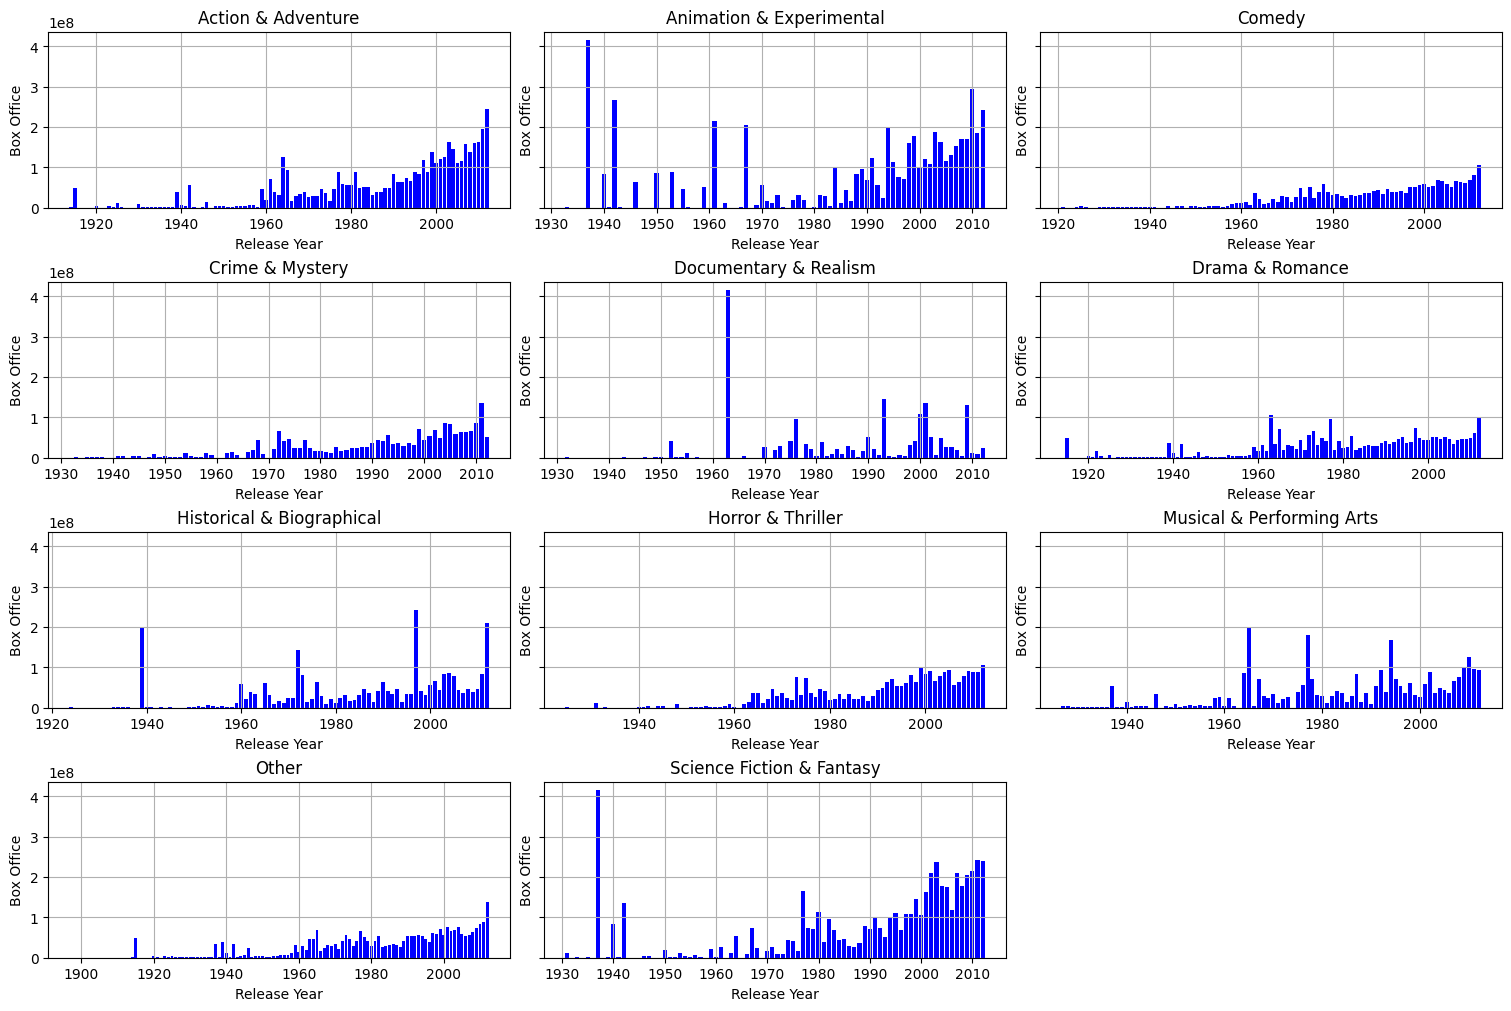

In [71]:
data_exploded = movies.explode('Dictionnary Movie genres')

genre_counts = data_exploded['Dictionnary Movie genres'].value_counts()
valid_genres = genre_counts.index
data_filtered = data_exploded[data_exploded['Dictionnary Movie genres'].isin(valid_genres)]

data_filtered = data_filtered.reset_index(drop=True)

def mean_without_nan_and_zero(x):
    non_zero_non_nan_revenues = x[(x != 0) & (~np.isnan(x))]
    if len(non_zero_non_nan_revenues) > 0:
        return np.mean(non_zero_non_nan_revenues)
    return np.nan

mean_revenue_per_year = data_filtered.groupby(['Dictionnary Movie genres', 'Movie release year'])['Movie box office revenue'].agg(mean_without_nan_and_zero).reset_index()

unique_genres = mean_revenue_per_year['Dictionnary Movie genres'].unique()

num_cols = 3
num_rows = (len(unique_genres) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharey=True, constrained_layout=True)

for i, genre in enumerate(unique_genres):
    ax = axes[i // num_cols, i % num_cols]
    genre_data = mean_revenue_per_year[mean_revenue_per_year['Dictionnary Movie genres'] == genre]

    x = genre_data['Movie release year']
    y = genre_data['Movie box office revenue']

    ax.bar(x, y, color='blue')
    ax.set_title(genre)
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Box Office')
    ax.grid(True)

for i in range(len(unique_genres), num_cols * num_rows):
    axes[i // num_cols, i % num_cols].axis('off')

plt.show()

Here, the mean revenue of each genre through the years. We wanted to visualise the evolution of the revenue of each genre and also see if there are genres that make more revenu than others.

We can observe that action & adventure, science fiction & Fantasy and animation and & experimental have a good revenue compared to the other and the evolution is pretty positive

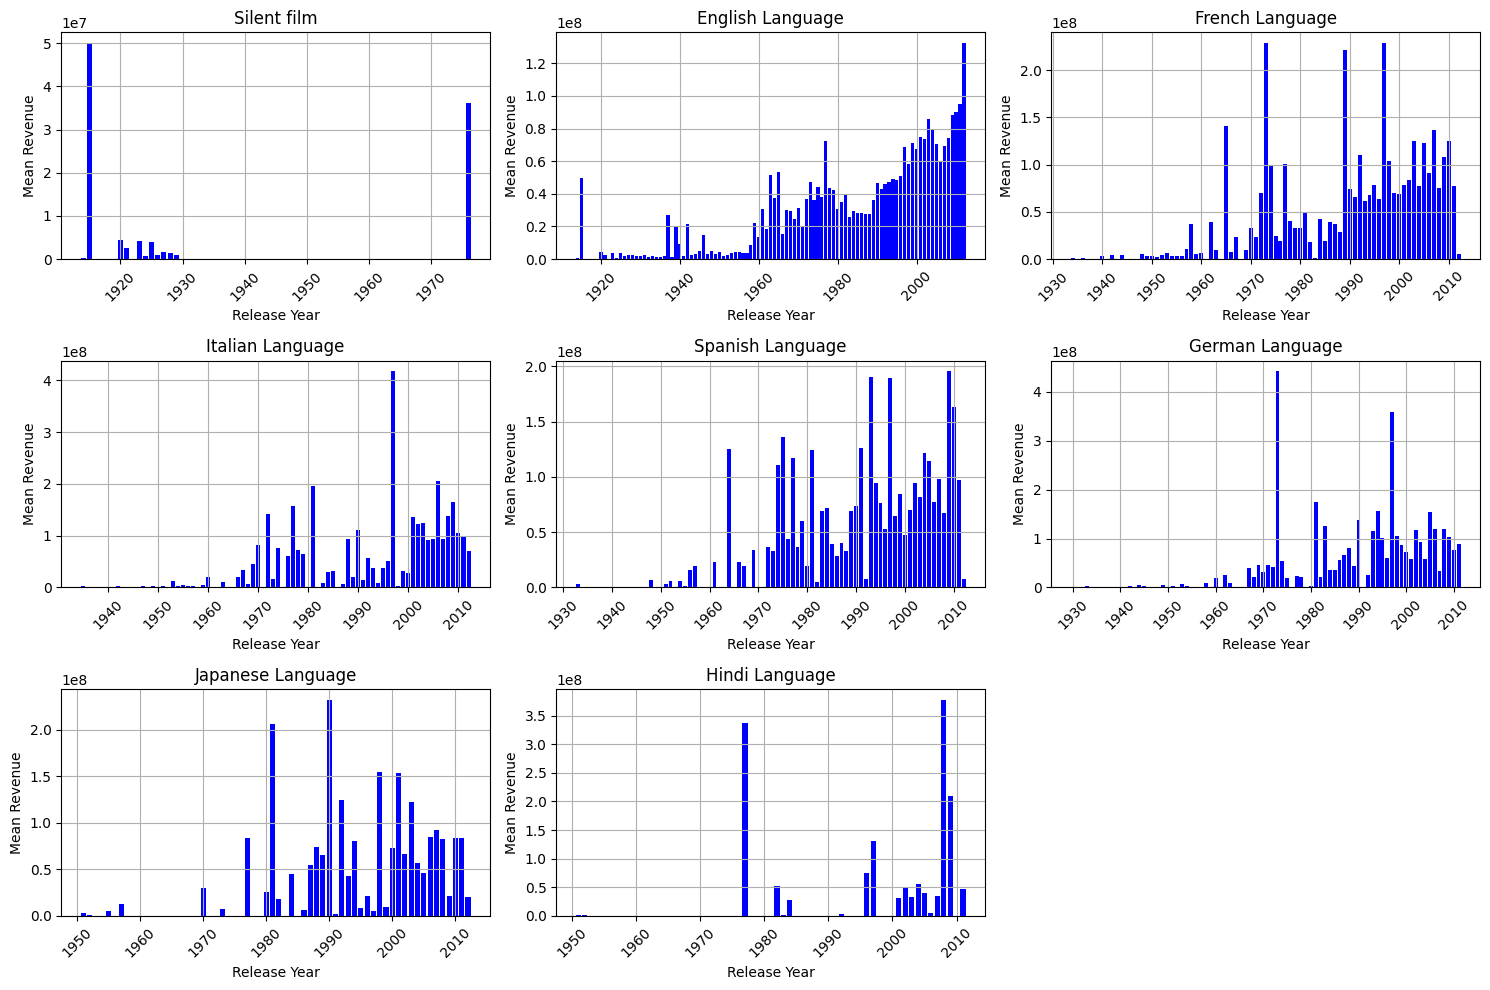

In [72]:

movies_expanded = movies.explode('Movie languages')

language_counts = movies_expanded['Movie languages'].value_counts()

selected_languages = language_counts[language_counts >= 2000].index.tolist()

movies_filtered = movies_expanded[movies_expanded['Movie languages'].isin(selected_languages)]

def mean_without_nan_and_zero(x):
    non_zero_non_nan_revenues = x[(x != 0) & (~np.isnan(x))]
    if len(non_zero_non_nan_revenues) > 0:
        return np.mean(non_zero_non_nan_revenues)
    return np.nan

mean_revenue_per_language = movies_filtered.groupby(['Movie release year', 'Movie languages'])['Movie box office revenue'].agg(mean_without_nan_and_zero).reset_index()

unique_languages = mean_revenue_per_language['Movie languages'].unique()


num_cols = 3
num_rows = (len(unique_languages) + num_cols - 1) // num_cols

plt.figure(figsize=(15, 10))

for i, language in enumerate(unique_languages):
    language_data = mean_revenue_per_language[mean_revenue_per_language['Movie languages'] == language]

    plt.subplot(num_rows, num_cols, i+1)
    plt.bar(language_data['Movie release year'], language_data['Movie box office revenue'], color='blue')
    plt.xlabel('Release Year')
    plt.ylabel('Mean Revenue')
    plt.title(language)
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

Here, we did the same as for the genre but with the language instead. We kept languages that occurs in at least 2000 movies. We wanted to see the evolution of the revenue through the years for each and language and if there are languages that stand out from the rest.

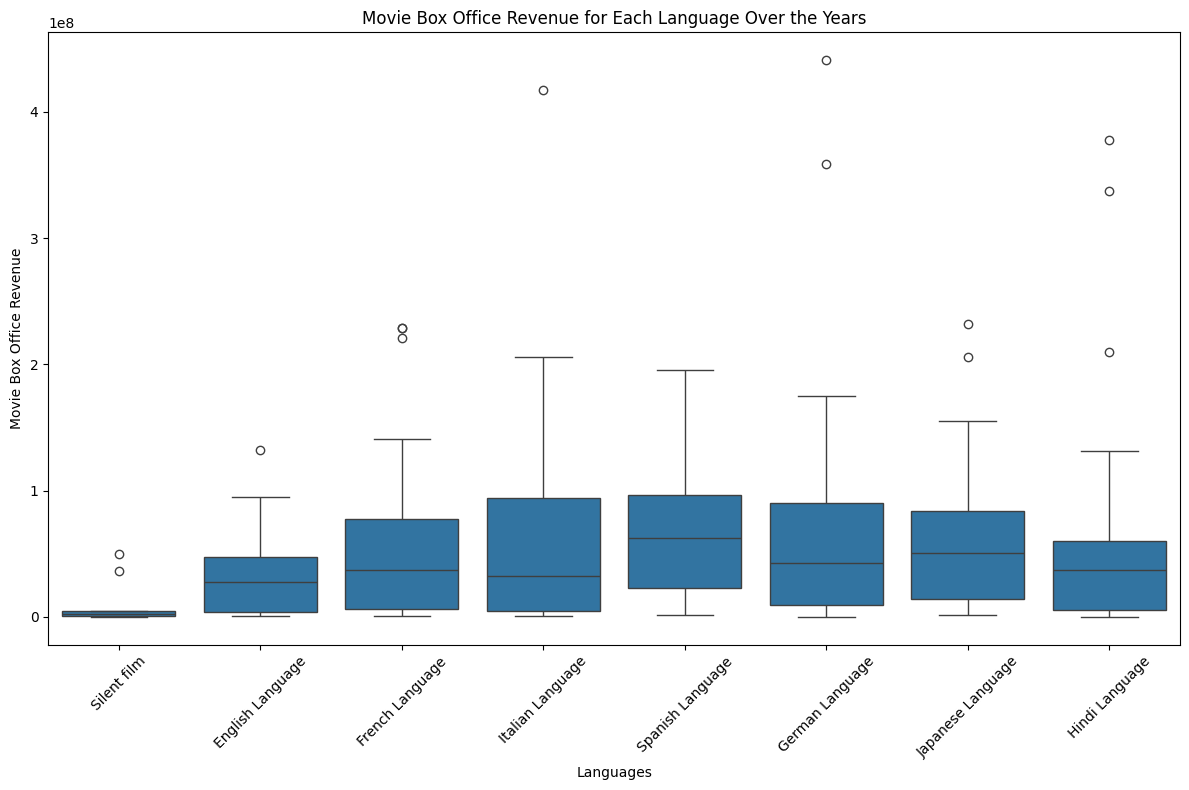

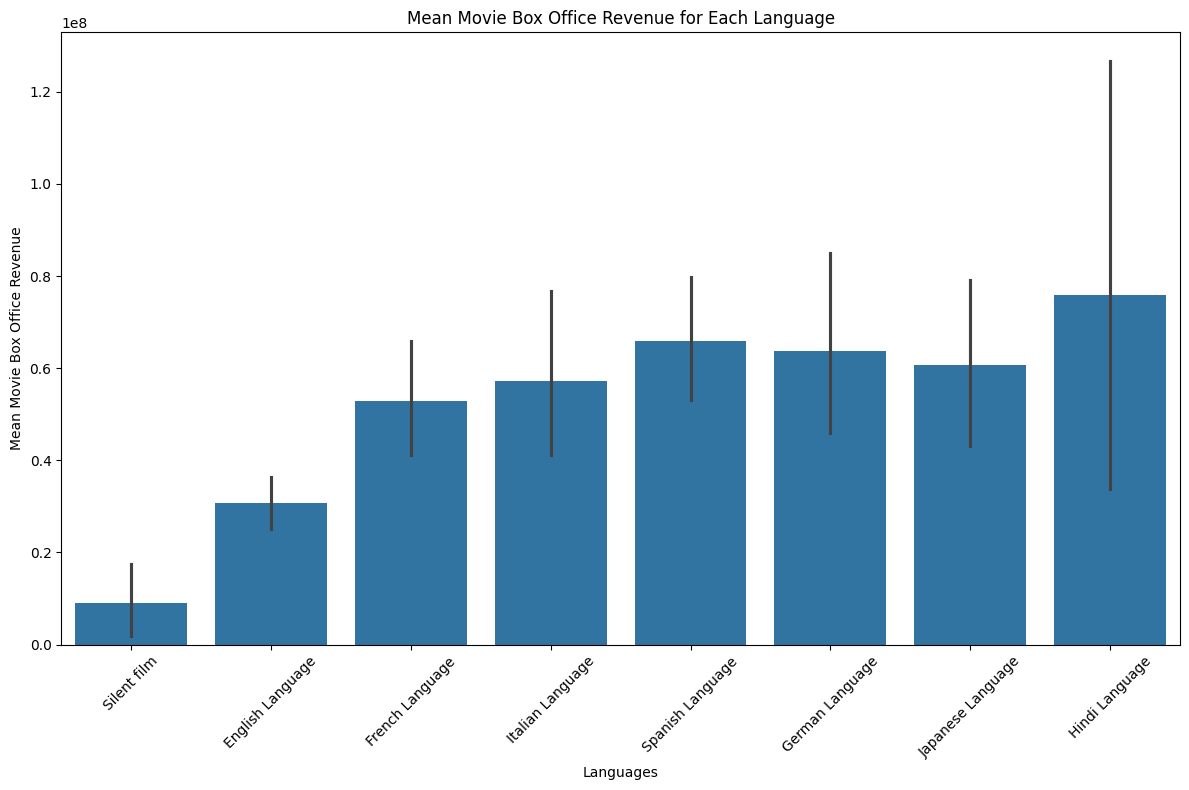

In [73]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Movie languages', y='Movie box office revenue', data=mean_revenue_per_language)
plt.xlabel('Languages')
plt.ylabel('Movie Box Office Revenue')
plt.title('Movie Box Office Revenue for Each Language Over the Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Movie languages', y='Movie box office revenue', data=mean_revenue_per_language, estimator=np.mean)
plt.xlabel('Languages')
plt.ylabel('Mean Movie Box Office Revenue')
plt.title('Mean Movie Box Office Revenue for Each Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


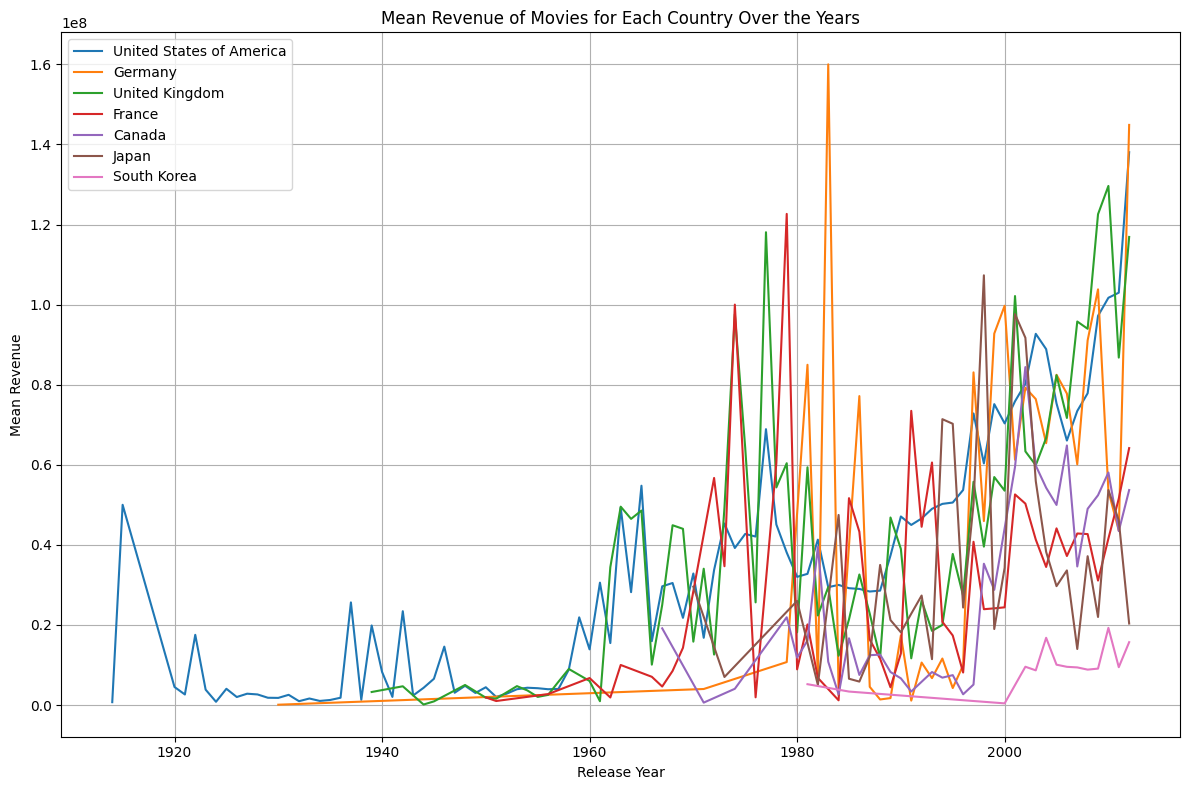

In [74]:
movies_filtered = movies[(movies['Movie box office revenue'].notnull()) & (movies['Movie box office revenue'] != 0)]

movies_expanded = movies_filtered.explode('Movie countries')

country_counts = movies_expanded['Movie countries'].value_counts()

selected_countries = country_counts[country_counts >= 200].index.tolist()

movies_filtered = movies_expanded[movies_expanded['Movie countries'].isin(selected_countries)]

mean_revenue_per_country = movies_filtered.groupby(['Movie release year', 'Movie countries'])['Movie box office revenue'].agg(lambda x: np.nanmean(x) if np.nanmean(x) != 0 else np.nan).reset_index()

plt.figure(figsize=(12, 8))

for country in mean_revenue_per_country['Movie countries'].unique():
    data = mean_revenue_per_country[mean_revenue_per_country['Movie countries'] == country]
    plt.plot(data['Movie release year'], data['Movie box office revenue'], label=country)

plt.xlabel('Release Year')
plt.ylabel('Mean Revenue')
plt.title('Mean Revenue of Movies for Each Country Over the Years')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

We ploted the evolution of the mean revenue of each country over the years. We only selected country that produces at least 200 films

10000.0
14999969.0


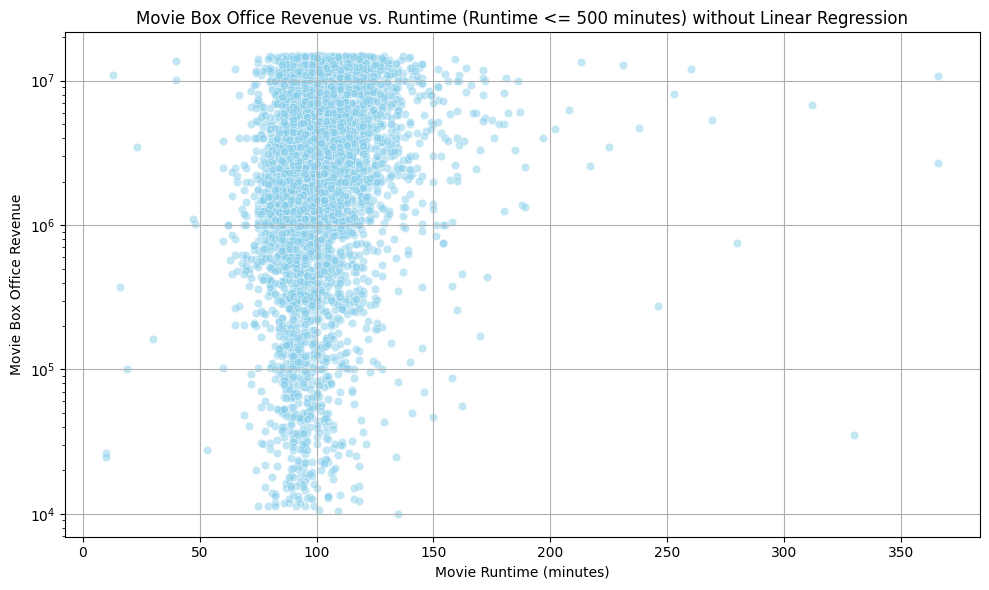

In [75]:
movies_filtered = movies[(movies['Movie runtime'].notnull()) &
                        (movies['Movie runtime'] != 0.0) &
                        (movies['Movie runtime'] <= 500) &
                        (movies['Movie box office revenue'] < 15000000) &
                        (movies['Movie box office revenue'] != 0.0)]

min_revenue = movies_filtered['Movie box office revenue'].min()
max_revenue = movies_filtered['Movie box office revenue'].max()

print(min_revenue)
print(max_revenue)


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Movie runtime', y='Movie box office revenue', data=movies_filtered, color='skyblue', alpha=0.5)
plt.xlabel('Movie Runtime (minutes)')
plt.ylabel('Movie Box Office Revenue')
plt.title('Movie Box Office Revenue vs. Runtime (Runtime <= 500 minutes) without Linear Regression')
plt.grid(True)
plt.yscale('log')
plt.tight_layout()

plt.show()


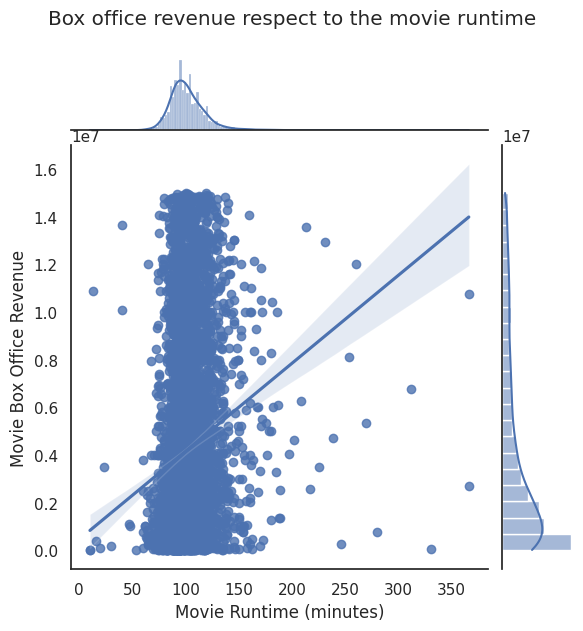

In [76]:
sns.set(style="white", color_codes=True)
g = sns.jointplot(data = movies_filtered, x = 'Movie runtime', y = 'Movie box office revenue', kind="reg")
g.ax_joint.set_xlabel('Movie Runtime (minutes)')
g.ax_joint.set_ylabel('Movie Box Office Revenue')
g.fig.suptitle('Box office revenue respect to the movie runtime', y=1.05)


plt.show()

/tmp/ipykernel_27877/2561757548.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average rating', y='Movie box office revenue', data=mean_revenue_per_rating, palette='viridis',)


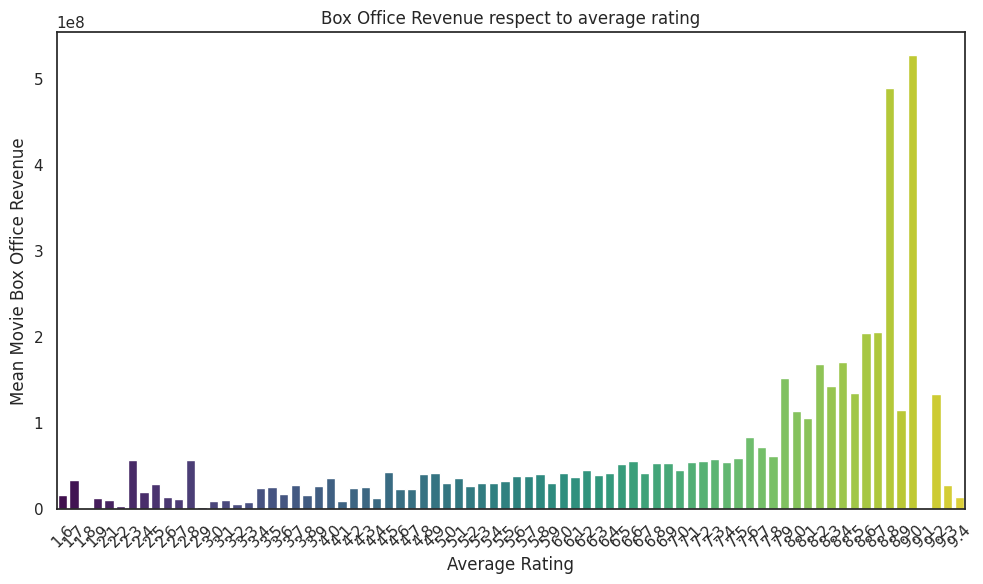

In [77]:
movies_filtered = movies[(movies['Movie box office revenue'].notnull()) & (movies['Movie box office revenue'] != 0)]

mean_revenue_per_rating = movies_filtered.groupby('Average rating')['Movie box office revenue'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Average rating', y='Movie box office revenue', data=mean_revenue_per_rating, palette='viridis',)
plt.xlabel('Average Rating')
plt.ylabel('Mean Movie Box Office Revenue')
plt.title('Box Office Revenue respect to average rating')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()


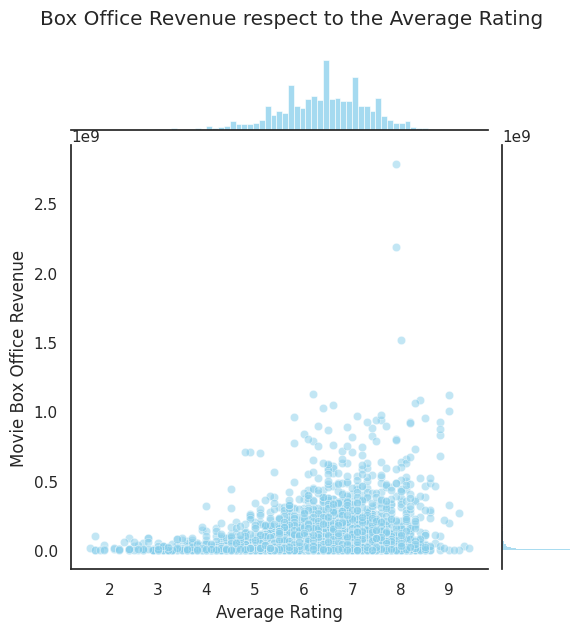

In [78]:
sns.set(style="white", color_codes=True)
g = sns.jointplot(data=movies_filtered, x='Average rating', y='Movie box office revenue', kind="scatter", color='skyblue', alpha=0.5)
g.ax_joint.set_xlabel('Average Rating')
g.ax_joint.set_ylabel('Movie Box Office Revenue')
g.fig.suptitle('Box Office Revenue respect to the Average Rating', y=1.05)

plt.show()

# Genders and revenue

Reload the dataset:

In [66]:
characters_movies = pickle.load(open('data/characters_movies_df_pickle', 'rb'))

In [22]:
#Gender distribution over the years
gender_distribution = characters_movies.groupby(['Movie release year', 'Actor gender']).size().unstack()
gender_distribution.fillna(0, inplace=True) #For the few cases where there are no gender represented
years_array = gender_distribution.index.astype(int).to_numpy() #It's easier to do custom graph with those

Packs the data per year, and for the few cases where there are no actor of a certain gender for some year, we put 0 instead of NaN.

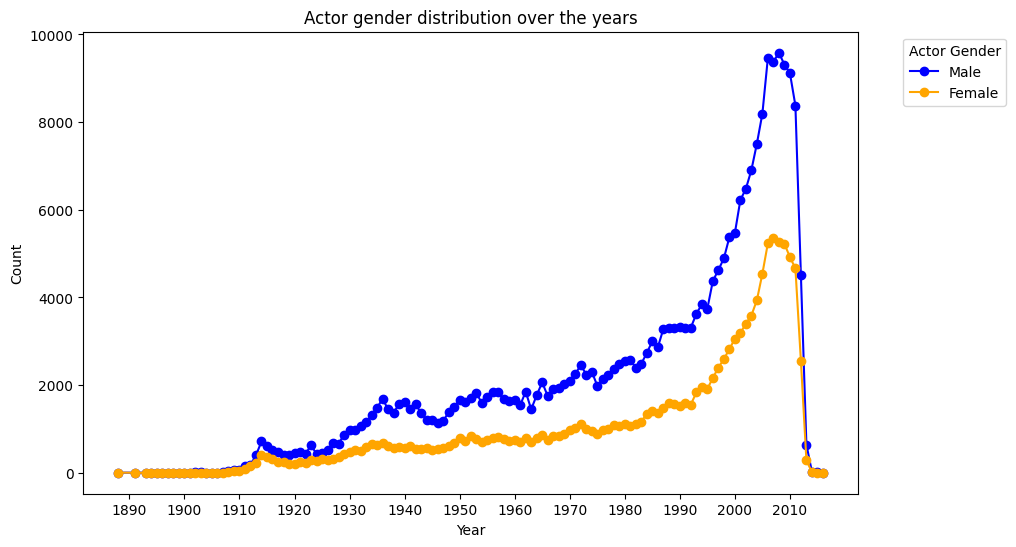

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
#2 curves
plt.plot(years_array, gender_distribution['M'], marker='o', linestyle='-', color='Blue', label='Male')
plt.plot(years_array, gender_distribution['F'], marker='o', linestyle='-', color='orange', label='Female')

plt.title('Actor gender distribution over the years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Actor Gender', loc='upper right', bbox_to_anchor=(1.2, 1))
#Better X axis
plt.xticks(np.arange(years_array[0]+2,years_array[-1], 10))
plt.show()

Of course, there are much more movie recoded in the database in recent years, leading the much more character. This plot does not show much, but it is a first step into the more interesting metric that is gender distribution

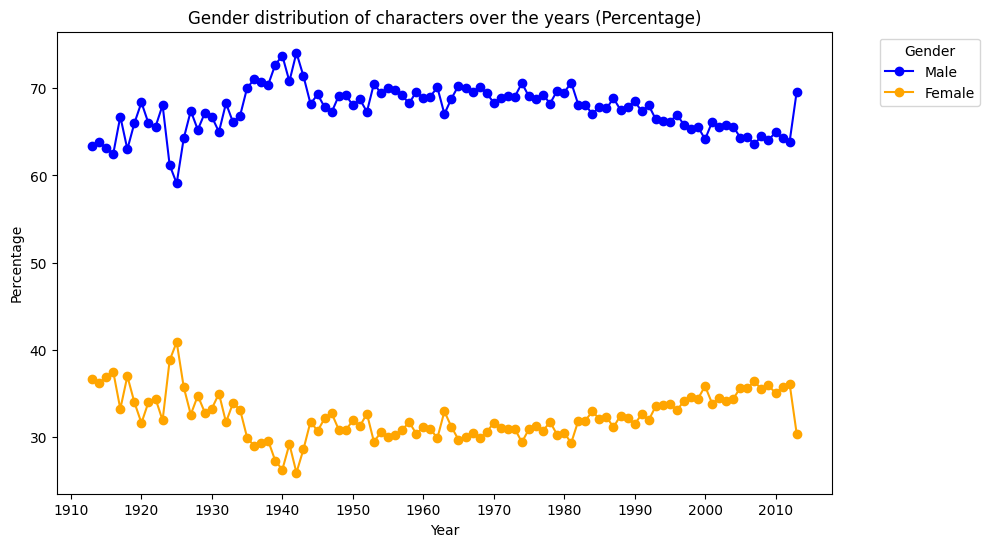

In [24]:
threshold=500

#Calculate percentage of male and female characters for each year (adds M+F and then divide each element of the base dataframe by that number)
gender_percentage = gender_distribution.div(gender_distribution.sum(axis=1), axis=0) * 100
# Filter years where the combined count of M and F is less than 100
filtered_years = gender_percentage.index[(gender_distribution.sum(axis=1) >= 500)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, gender_percentage.loc[filtered_years, 'M'], marker='o', linestyle='-', color='blue', label='Male')
plt.plot(filtered_years, gender_percentage.loc[filtered_years, 'F'], marker='o', linestyle='-', color='orange', label='Female')

plt.title('Gender distribution of characters over the years (Percentage)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))

# Better X axis
plt.xticks(np.arange(filtered_years[0]-3, filtered_years[-1], 10))
plt.show()

This is on a yearly basis, and we notice that the ratio remain rather constant.

In [25]:
#Drop duplicate actors, keeping only the first occurrence
unique_actors = characters_movies.drop_duplicates(subset='Actor name')
#Count the number of unique actors for each ethnicity
ethnicity_counts = unique_actors.groupby('Actor ethnicity (Freebase ID)').size()
#Print or use the counts as needed
print("Ethnicity Counts:")
print(ethnicity_counts)
#It's horrible let's not use that

Ethnicity Counts:
Actor ethnicity (Freebase ID)
/m/01267        2
/m/012c1l       7
/m/012f86       7
/m/012fh        1
/m/01336l      30
             ... 
/m/0j4w_        2
/m/0j6x8       17
/m/0x67      1464
/m/0xff         2
/m/0xnvg      139
Length: 479, dtype: int64


There are way to many ethnicity in order to really be able to make sense of it. Plus, the hash are depreciated and would need to find another dataset in order to get the information. Ethnicity seems like a good idea in theory, but it is too precise of a metric to really be able to take it into account to make any sort of diversity comment.

Instead of taking care of every movie, and to tie back to our research base, we will now be looking only at the most successfull movie of a periode. Either successfull by Box office, or by rating. The following plots are taking into account only the top X% movie of each N year range.

In [26]:
top = 20
year_range = 10
threshold = 100

# Create N-year range groups
characters_movies['Year group'] = (characters_movies['Movie release year'] // year_range) * year_range

# Calculate the number of movies needed to cover the top X% for each group
num_movies_to_select = (
    characters_movies.groupby('Year group')
    .apply(lambda group: int(len(group) * top / 100))
    .astype(int)
    .to_dict()
)

# Filter out groups with less than the threshold number of movies
valid_groups = characters_movies['Year group'].value_counts() >= threshold
characters_movies_filtered = characters_movies[characters_movies['Year group'].isin(valid_groups[valid_groups].index)]

# Select the top X% for each group based on box office revenue
sorted_BO = characters_movies_filtered.sort_values(by=['Year group', 'Movie box office revenue'], ascending=[True, False])
top_movies_BO = sorted_BO.groupby('Year group').apply(lambda group: group.head(num_movies_to_select[group.name]))
top_movies_BO = top_movies_BO.reset_index(drop=True)

# Same for rating
sorted_rating = characters_movies_filtered.sort_values(by=['Year group', 'Average rating'], ascending=[True, False])
num_movies_to_select_rating = sorted_rating.groupby('Year group').apply(lambda group: int(len(group) * top / 100))

# Select the top X% for each group based on rating
top_movies_rating = sorted_rating.groupby('Year group').apply(lambda group: group.head(num_movies_to_select_rating[group.name]))
top_movies_rating = top_movies_rating.reset_index(drop=True)


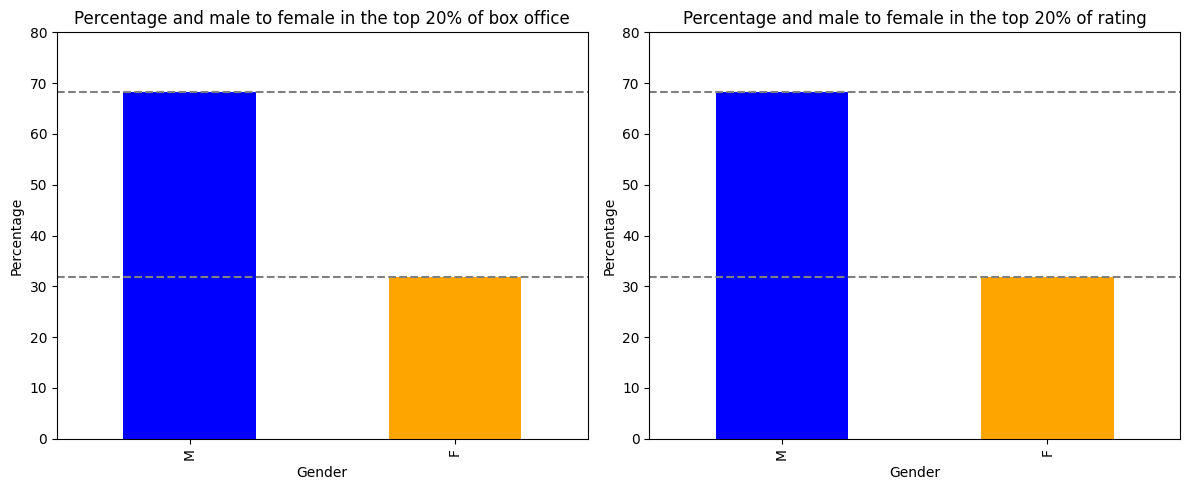

In [27]:
#Overall, if we group by "year range"

#Calculate the percentage of male to female in the top X% for box office revenue
percentage_male_to_female_BO = top_movies_BO['Actor gender'].value_counts(normalize=True) * 100

#Calculate the percentage of male to female in the top X% for rating
percentage_male_to_female_rating = top_movies_rating['Actor gender'].value_counts(normalize=True) * 100
#Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
#Box Office Revenue
percentage_male_to_female_BO.plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title(f"Percentage and male to female in the top {top}% of box office")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Gender")

#Rating
percentage_male_to_female_rating.plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title(f"Percentage and male to female in the top {top}% of rating")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Gender")

#Calculate the maximum value of the 'M' bar in the first plot
max_value_M_BO = percentage_male_to_female_BO['M'].max()

#Draw a horizontal line at the top of the 'M' bar in the first plot
axes[0].axhline(y=max_value_M_BO, color='gray', linestyle='--')
axes[1].axhline(y=max_value_M_BO, color='gray', linestyle='--')

#Calculate the maximum value of the 'M' bar in the first plot
max_value_F_BO = percentage_male_to_female_BO['F'].max()

#Draw a horizontal line at the top of the 'M' bar in the first plot
axes[0].axhline(y=max_value_F_BO, color='gray', linestyle='--')
axes[1].axhline(y=max_value_F_BO, color='gray', linestyle='--')


axes[0].set_ylim(0,80)
axes[1].set_ylim(0,80)
plt.tight_layout()
plt.show()

Now we look at all the best movies of the dataset and look at the male and female character pourcentage. From this, we cannot see any noticable effect, and that the ratio remain similar between movies that perform well money wise, and movies that were rated the best.

Hence, maybe time is a important aspect. We will now look at that same ratio of male to female character, but considering a grouping of years. We keep considering only the most succesfull movies

In [28]:
#Calculate the percentage of male to female in the top X% for BO, per grouped years
percentage_male_to_female_BO_per_group = top_movies_BO.groupby('Year group')['Actor gender'].value_counts(normalize=True) * 100
#Calculate the percentage of male to female in the top X% for rating, per grouped years
percentage_male_to_female_rating_per_group = top_movies_rating.groupby('Year group')['Actor gender'].value_counts(normalize=True) * 100

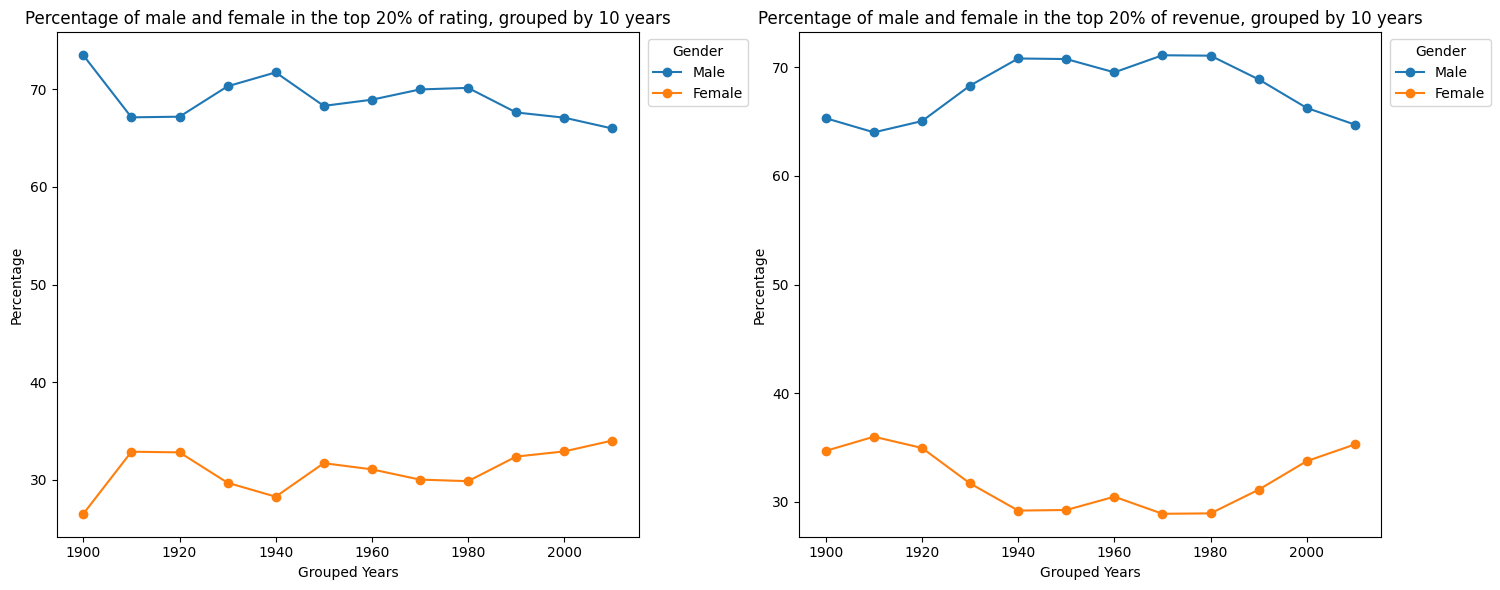

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

#Plot for rating
data_m_rating = percentage_male_to_female_rating_per_group.xs('M', level='Actor gender')
data_f_rating = percentage_male_to_female_rating_per_group.xs('F', level='Actor gender')


axs[0].plot(data_m_rating.index, data_m_rating.values, marker='o', label='Male')
axs[0].plot(data_f_rating.index, data_f_rating.values, marker='o', label='Female')
axs[0].set_title(f"Percentage of male and female in the top {top}% of rating, grouped by {year_range} years")
axs[0].set_ylabel("Percentage")
axs[0].set_xlabel("Grouped Years")
axs[0].legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))

#Plot for box office
data_m_bo = percentage_male_to_female_BO_per_group.xs('M', level='Actor gender')
data_f_bo = percentage_male_to_female_BO_per_group.xs('F', level='Actor gender')
axs[1].plot(data_m_bo.index, data_m_bo.values, marker='o', label='Male')
axs[1].plot(data_f_bo.index, data_f_bo.values, marker='o', label='Female')
axs[1].set_title(f"Percentage of male and female in the top {top}% of revenue, grouped by {year_range} years")
axs[1].set_ylabel("Percentage")
axs[1].set_xlabel("Grouped Years")
axs[1].legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))


plt.tight_layout()
plt.show()

Now we can see how those evolved throught the years. This could lead to some more advanced analysis for later down the pipeline

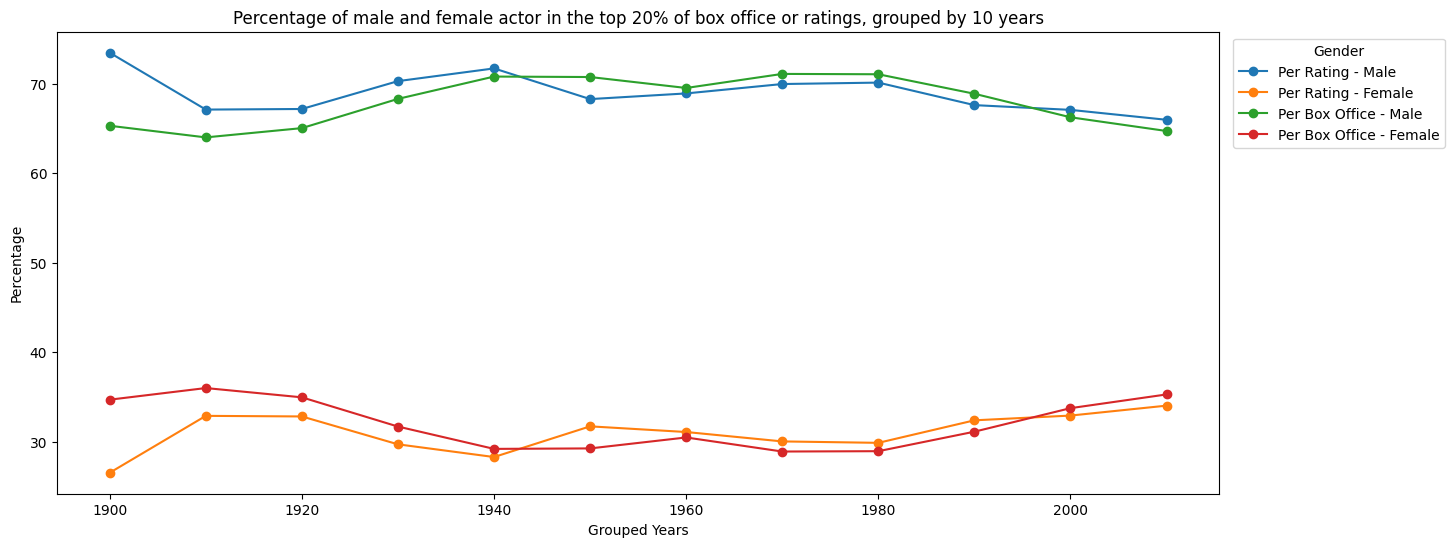

In [30]:

plt.figure(figsize=(15, 6))

#Plot for Rating
plt.plot(data_m_rating.index, data_m_rating.values, marker='o', label='Per Rating - Male')
plt.plot(data_f_rating.index, data_f_rating.values, marker='o', label='Per Rating - Female')

#Plot for Box Office
plt.plot(data_m_bo.index, data_m_bo.values, marker='o', label='Per Box Office - Male')
plt.plot(data_f_bo.index, data_f_bo.values, marker='o', label='Per Box Office - Female')

plt.title(f"Percentage of male and female actor in the top {top}% of box office or ratings, grouped by {year_range} years")
plt.ylabel("Percentage")
plt.xlabel("Grouped Years")
plt.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Comparing that ratio in the case of box office succesfull movie and rating sucessfull movies, we can see a slight difference in the trends. We might consider to look into those for later. And this answer an hypothesis that movie that would have a better rating would have a more divers cast. This does not appear to be the case. Maybe it depends on the genre of the movie. We might look into it.

# Analysis of influence of actors' fame to revenue

We want to quantify the actors' fame in some way. We decided to consider actor's career span, number of movies they starred in, average box office revenue and the average rating of movies they appeared in. Let's delve right in. 

Reload the dataset:

In [51]:
characters_movies = pickle.load(open('data/characters_movies_df_pickle', 'rb'))

Let's calculate actors' career span:

In [48]:
first_movie_year = characters_movies.groupby('Actor name')['Movie release year'].min()

years_of_casting = characters_movies.groupby('Actor name')['Movie release year'].max() - first_movie_year + 1


Calculate the number of movies for each actor:

In [53]:
number_of_movies = characters_movies.groupby('Actor name')['Movie name'].nunique()

Another parameter we want to check out is the average box office revenue of the movies they appeared in:

In [55]:
average_box_office = characters_movies.groupby('Actor name')['Movie box office revenue'].mean()
# For now, let's change the average box offcie with zero. If the actor acted only in the movies
# for which the budget is not recorded, chances are the movies weren't that successful. Might be
# changed later.
average_box_office = average_box_office.fillna(0)

When calculating the average rating, we should consider the number of votes given to a movie. We must also deal with NANs, replacing them by 0, using the same reasoning as with the budget.

In [54]:
characters_movies['Weighted Rating'] = characters_movies['Average rating'].fillna(0) * characters_movies['Number of votes'].fillna(0)

# Group by actor name and having sums of weighted ratings and number of votes (calcluate it same as for credits at EPFL)
actor_grouped = characters_movies.groupby('Actor name').agg({
    'Weighted Rating': 'sum',#sum of all grades*credits
    'Number of votes': 'sum'#total credits
})

# Calculate the weighted average rating for each actor(same as for credits at EPFL)
# Replace by NaNs if the denominator is zero, result in having a NAN value instead of dividing by 0
actor_grouped_average = actor_grouped['Weighted Rating'] / actor_grouped['Number of votes'].replace({0: np.nan})
#replace NANs by 0
actor_grouped_average.fillna(0, inplace=True)

Put newly calculated data into a dataframe:

In [56]:
#Create a new DF with these features for calculating actors popularity
actor_fame_df = pd.DataFrame({
    'Actor Name': number_of_movies.index,
    'Years Since First Movie': years_of_casting.values,
    'Number of Movies': number_of_movies.values,
    'Average Box Office Revenue': average_box_office.values,
    'Average Movie Rating': actor_grouped_average.values,

})


#reset indexes,drop old indexes
actor_fame_df.reset_index(drop=True, inplace=True)

Before further analysis, columns should be normalized:

In [ ]:
#list of columns to normalize
columns_to_normalize = ['Years Since First Movie', 'Number of Movies', 'Average Box Office Revenue', 'Average Movie Rating']

#Let's apply z-score normalization
for column in columns_to_normalize:
    mean_col = actor_fame_df[column].mean()
    std_col = actor_fame_df[column].std()
    actor_fame_df[column] = (actor_fame_df[column] - mean_col) / std_col

# Now actor_fame_df has normalized values for each of it's columns

We construct a simple model by hand. Currently, this is a placeholder we arrived at by trial and error. It should in the future be replaced by a more serious regression model, perhaps using external datasets (top actors lists) for training.

In [57]:
weights = {
    'Years Since First Movie': 0.15,
    'Number of Movies': 0.6,
    'Average Box Office Revenue': 0.0,
    'Average Movie Rating': 0.25
}


# Calculate fame score
actor_fame_df['Fame Score'] = (actor_fame_df['Years Since First Movie'] * weights['Years Since First Movie'] +
                    actor_fame_df['Number of Movies'] * weights['Number of Movies'] +
                    actor_fame_df['Average Box Office Revenue'] * weights['Average Box Office Revenue'] +
                    actor_fame_df['Average Movie Rating'] * weights['Average Movie Rating'])


Finally, who are the most famous actors ever?

In [65]:
sorted_df = actor_fame_df.sort_values(by='Fame Score', ascending=False)
sorted_df[['Actor Name', 'Fame Score']].head(20)

,Actor Name,Fame Score
86136,Mel Blanc,359.004755
90201,Mithun Chakraborty,200.892069
95972,Oliver Hardy,196.608104
90355,Moe Howard,152.9988
90474,Mohanlal,147.823199
72567,Larry Fine,146.22915
79708,Mammootty,143.736786
30021,Dharmendra Deol,139.373189
101832,Prakash Raj,128.228638
15231,Brahmanandam,125.104365


This list of actors seems odd. This is because of the placeholder model, which will be replaced in future iterations.

# Topic analysis and extraction of movie themes

## DATA LOADING & CONSTANTS

In [32]:
import os
from nlp_word_extraction import load_summaries

In [33]:
DATA_PATH = 'data/MovieSummaries/'
SPACY_PATH = 'spacy_results'
LDA_PATH = 'lda_models'

Load summaries:

In [34]:
movie_summaries = load_summaries(DATA_PATH)

The NLP task was done earlier and results were saved with  <span style="font-family: 'Courier New', monospace; font-size: 11pt;">pickle</span>. Extraction of words based on their POS was done using  <span style="font-family: 'Courier New', monospace; font-size: 11pt;">spacy</span> module, since it had NER in its pipeline, which allowed the removal of names. In the first iteration, words were extracted using  <span style="font-family: 'Courier New', monospace; font-size: 11pt;">nltk</span> and the set of nouns turned out to be severely polluted by character names. Though LDA found the names to be an important predictor to determine film's topics, they do not carry much information about the ideas in the film. That is why we opted to remove them from the set.

Since this step of the process takes about ~40 minutes, and is unlikely to change during the work on the process, we opted to do it once and save the results using <span style="font-family: 'Courier New', monospace; font-size: 11pt;">pickle</span>. The program  <span style="font-family: 'Courier New', monospace; font-size: 11pt;">nlp_word_extraction.py</span> contains the code used for word extraction.

Load dictionaries with extracted nouns, verbs and descriptions (adverbs and adjectives):

In [35]:
import pickle

In [36]:
with open(os.path.join(SPACY_PATH, 'nouns.pickle'), 'rb') as handle:
    nouns = pickle.load(handle)

with open(os.path.join(SPACY_PATH, 'verbs.pickle'), 'rb') as handle:
    verbs = pickle.load(handle)

with open(os.path.join(SPACY_PATH, 'descs.pickle'), 'rb') as handle:
    descs = pickle.load(handle)

with open(os.path.join(SPACY_PATH, 'all_words.pickle'), 'rb') as handle:
    all_words = pickle.load(handle)

## LDA topic modeling

In [37]:
import gensim
from gensim import corpora

### LOADING PREVIOUSLY TRAINED MODEL

Training the LDA model takes anywhere from a few minutes to a few dozen of minutes, so we can just load the one that was trained earlier:

In [38]:
ldamodel = gensim.models.LdaModel.load(os.path.join(LDA_PATH, 'lda_1_all_words.pickle'))

Reorganize the data so that it complies with what gensim is expecting:

In [39]:
dictionary = corpora.Dictionary(list(all_words.values()))
corpus = [dictionary.doc2bow(text) for text in list(all_words.values())]

### TRAINING A NEW MODEL

**NOTE:** In general, it takes a long time to train the model, so we avoid it. **SKIP THIS PART IF YOU ONLY WANT TO USE ALREADY TRAINED MODELS!!!**

Train the model:

In [ ]:
NUM_TOPICS = 30
ldamodel = gensim.models.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

Depending on the number of topics, the training might take anywhere from a few minutes to a few dozen minutes. So, let's save the progress:

In [ ]:
ldamodel.save('lda_1_all_words.pickle')

### CHECKING OUT THE TRAINED MODEL

Take a look at the topics:

In [ ]:
for topic in ldamodel.show_topics(formatted=False):
    print(topic)

(23, [('father', 0.016632823), ('mother', 0.016005652), ('child', 0.014292926), ('life', 0.010872081), ('son', 0.010193523), ('year', 0.010095454), ('family', 0.010085811), ('home', 0.008011227), ('old', 0.007783101), ('leave', 0.0075211017)])
(26, [('film', 0.017647702), ('scene', 0.01171323), ('end', 0.0075777983), ('woman', 0.007547428), ('sex', 0.0067756586), ('show', 0.0063152406), ('song', 0.0060756304), ('club', 0.005835483), ('time', 0.005624249), ('perform', 0.0051543177)])
(11, [('life', 0.01321674), ('love', 0.009374952), ('find', 0.009141725), ('work', 0.008370809), ('live', 0.0078122006), ('woman', 0.0060528233), ('fall', 0.0055049025), ('decide', 0.0054360926), ('man', 0.0054030083), ('apartment', 0.005352825)])
(17, [('team', 0.016593192), ('school', 0.016086554), ('game', 0.0142987035), ('play', 0.013453068), ('band', 0.011307224), ('friend', 0.010226646), ('win', 0.0078588445), ('player', 0.007570003), ('girl', 0.0064968904), ('music', 0.0062142545)])
(29, [('kill', 0.

Let's check out some movies. You can select different ones by changing the $i$ parameter.

In [ ]:
i=5
print(movie_summaries[i][0])
new_doc_bow = dictionary.doc2bow(all_words[movie_summaries[i][1]['id']])
topic_list = sorted(ldamodel.get_document_topics(new_doc_bow), key=lambda x: x[1], reverse=True)
print(topic_list)

The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by the bullet that hits the president. The shooter is gunned down by Alex and other secret service agents. The president dies at the hospital. Kate Crawford , an investigative journalist, starts asking questions about the assassination. Anyone she questions is killed. She goes to Alex Thomas's house to tell him what is happening. As they head to his boat, Thomas sees some men hiding in the bushes. He throws Kate into the water and dives in. Thomas jumps out of the water to kill two of the hitmen while a third hitman drives off to inform his boss what happened. They are able to link the hitmen to a man called Jack Baldwin . Agent Thomas and other Secret Service members attack the location of Jack Bal

## Result analysis

In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Extract the set of unique words:

In [ ]:
unique_words    = [word_pair[0] for _, wordlist \
                    in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False) \
                    for word_pair in wordlist]
unique_words = list(set(unique_words))

Create a new pandas DataFrame to keep al the useful statistical information:

In [ ]:
word_ids = pd.Series(unique_words)
dtypes={'sum': 'float64', 'occ': 'int', 'avg': 'float64'}
wts = pd.DataFrame({'word': unique_words, 'sum': 0.0, 'occ': 0, 'avg': 0.0},
                    index=word_ids)

$sum$ column represents the sum of all weight factors in different topics for a given word, while $occ$ and $avg$ are the number of occurences of the word in different topics and the average of all of its weight factors, respectively. Calculating those parameters:

In [ ]:
for topic_num, topic_words in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False):
    for word, weight in topic_words:
        wts.loc[word, 'sum'] += np.float64(weight)
        wts.loc[word, 'occ'] += 1

In [ ]:
wts['avg'] = wts['sum'] / wts['occ']

Add normalized columns for better comparison:

In [ ]:
wts['navg'] = (wts['avg'] - wts['avg'].mean()) / wts['avg'].std()
wts['nsum'] = (wts['sum'] - wts['sum'].mean()) / wts['sum'].std()

Check out the most often occuring words:

In [ ]:
wts.sort_values(by='occ', ascending=False).head()

,word,sum,occ,avg,navg,nsum
find,find,0.194830,24,0.008118,0.173952,7.921170
take,take,0.102031,20,0.005102,-0.532703,3.787864
leave,leave,0.113543,18,0.006308,-0.250072,4.300635
try,try,0.088629,17,0.005213,-0.506481,3.190944
man,man,0.124889,15,0.008326,0.222690,4.805991


A helper function for setting y-axis limits on plots:

In [ ]:
def get_ylims(data_series):
    lim = max(np.abs(np.max(data_series)), np.abs(np.min(data_series)))
    return (-lim - 0.1*lim, lim + 0.1*lim)

A helper function for plotting two barplots on the same plot, with two separate y axes:

In [ ]:
def plot_n_sum_avg(data_frame, title, normalized=True):
    """Plot sums and averages of word weights side-by-side on the same
    plot. Each will have its own y-axis, while the x-axis is shared.

    Args:
        data_frame: pd.DataFrame. Must contain columns [word, sum, occ, 
        avg, nsum, navg].
        title: str. Plot title.
        normalized: bool, default=True. If true, plot the normalized
        colummns, otherwise, plot the original values.

    Returns:
        None.
    """
    bar_width = 0.35
    c1 = '#2ecc71'  # Color for the 1st plot
    c2 = '#9b59b6'  # Color for the 2nd plot

    if normalized:
        sum_series = data_frame['nsum']
        avg_series = data_frame['navg']
    else:
        avg_series = data_frame['avg']
        sum_series = data_frame['sum']

    # Generate x values based on the DataFrame index
    x = np.arange(len(data_frame))

    # Create the first bar plot on the left y-axis
    fig, ax1 = plt.subplots(figsize=(14,6))
    ax1.bar(x, sum_series, width=bar_width, color=c1, label='Normalized total weight', bottom=0)
    ax1.set_xlabel('Word')
    ax1.set_ylabel('Normalized total weight', color=c1)
    ax1.tick_params('y', colors=c1)

    # Create a a second bar plot on the right y-axis
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width, avg_series, width=bar_width, color=c2, label='Normalized average weight', bottom=0)
    ax2.set_ylabel('Normalized average weight', color=c2)
    ax2.tick_params('y', colors=c2)

    # Set symmetrical ylims if plotting normalized data.
    if normalized:
        ax1.set_ylim(get_ylims(sum_series))
        ax2.set_ylim(get_ylims(avg_series))

    # Plot y=0 line for prettier plot
    plt.axhline(y=0, color='black', linestyle='--')

    # Set x-axis ticks and labels
    ax1.set_xticks(x + bar_width / 2)
    ax1.set_xticklabels(data_frame['word'])

    # Set title and legend
    plt.title(title)
    fig.tight_layout()

    plt.show()

Plot the total and average weights for most commonly occuring words:

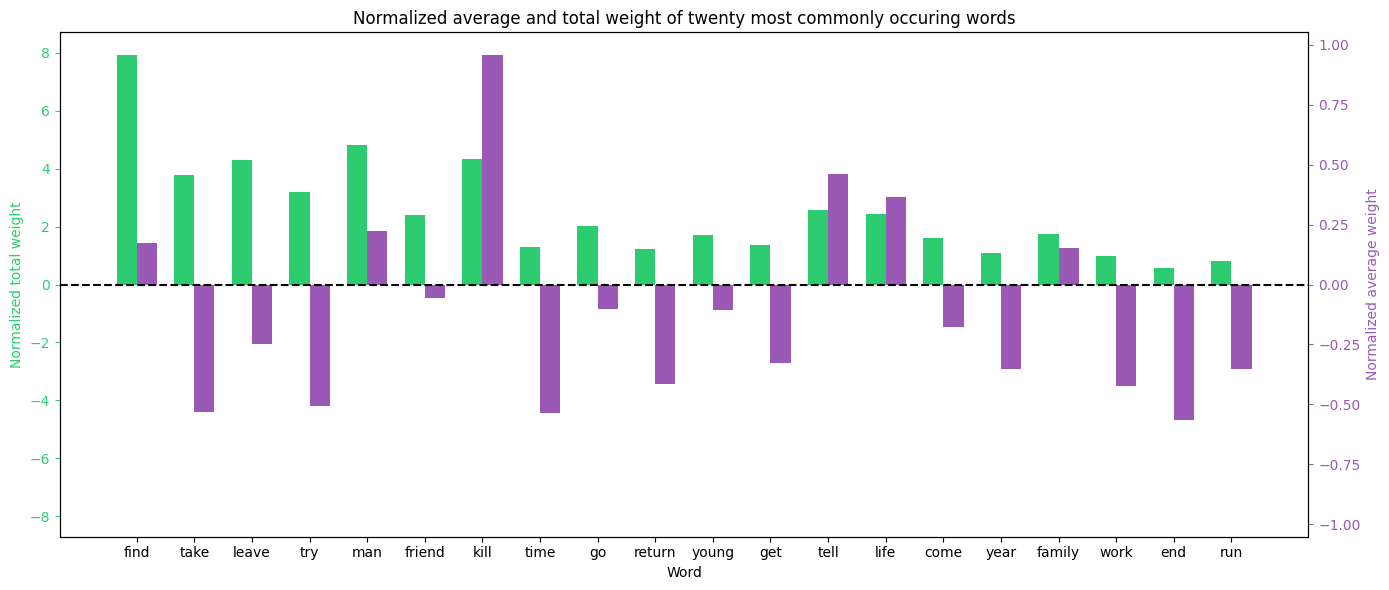

In [ ]:
top_20_cnt = wts.sort_values(by='occ',  ascending=False).head(20)
plot_n_sum_avg(top_20_cnt, 'Normalized average and total weight of twenty most commonly occuring words')


Do it for the least commonly occuring ones:

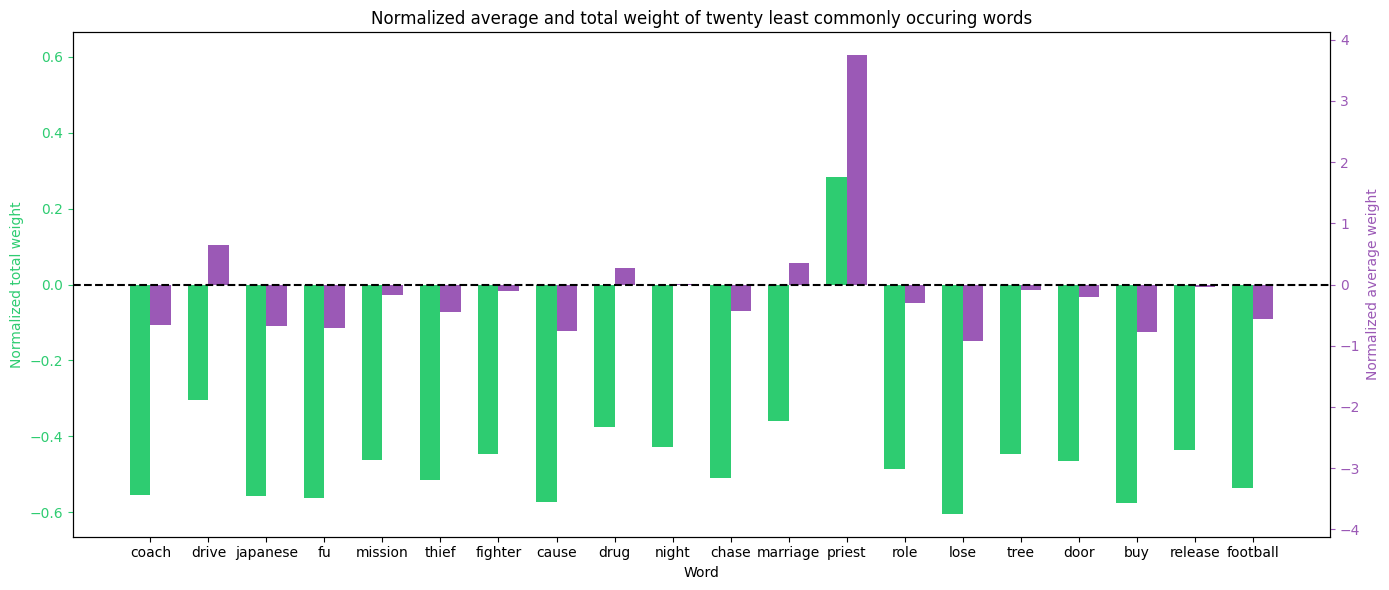

In [ ]:
bottom_20_cnt = wts.sort_values(by='occ', ascending=True).head(20)
plot_n_sum_avg(bottom_20_cnt, 'Normalized average and total weight of twenty least commonly occuring words')

We see that there are some words that have a high average weight with low total weight and vice versa. If the average weight is high and the total is low, it means that those words are very important to a small number of topics. The inverse situation means that the words appear often, but carry little importance to the topics they appear in. Let's check which words are the most specific to their respective topics.

Transform the data from the lda model into a list of (topic_id, word, weight) triplets:

In [ ]:
most_important_words = []
for topic_num, topic_words in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False):
    for word, score in topic_words:
        most_important_words.append([topic_num, word, score])

If we divide each weight with the sum of weights, we should get info about how specific is the word to a certain topic. If the word appears in many topics, this ratio should tend to be small. Furthermore, if the word is equally important to many topics, this should push the ratio further down. On the other hand, if the ratio is 1, that means the word appears only in one topic.

In [ ]:
for i, word in enumerate(most_important_words):
    most_important_words[i][2] = most_important_words[i][2] / wts.loc[word[1], 'sum']

In [ ]:
sorted(most_important_words, key=lambda x: x[2], reverse=True)[:15]

[[0, 'slave', 1.0],
 [0, 'monk', 1.0],
 [0, 'nun', 1.0],
 [0, 'convent', 1.0],
 [0, 'arrive', 1.0],
 [1, 'make', 1.0],
 [1, 'lose', 1.0],
 [1, 'offer', 1.0],
 [2, 'island', 1.0],
 [2, 'horse', 1.0],
 [2, 'race', 1.0],
 [2, 'treasure', 1.0],
 [2, 'pirate', 1.0],
 [2, 'sea', 1.0],
 [2, 'sail', 1.0]]

This list of sorted words is useful for interpreting topics. For example, topic 0 seems to have to do with religion, while topic 2 might be connected to pirates. The naming of the topic, in the end, is a qualitative and subjective task, and this result should aid in interpretation.

## FILM MOTIVES: TODO

As the project unfolds, the idea is to check how these extracted topics relate to some other movie descriptors, most noteably genre. There should be some correlation (a pirate movie should be related to the pirate topic), but our hope is that these topic capture more fine-grained characteristics of the film. For example, a pirate flick might feature a romance story between Orlano Bloom and Keira Knightley, so it should also relate to the love topic. This might also serve as a way to validate the obtained topics.

Second part of analysis shall focus on the relation of movie motives to the box office. Stationary analysis shall be used to determine the absolute influence of motives on revenue, while temporal analysis could give us an insight on how the ideas represented in the movies evolved over time. It should be interesting to see the relation of genre and motives time series and if they follow simillar patterns.